In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [88]:
def resize_image(image, size):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def detect_features(images_grey):
    sift = cv2.SIFT_create()
    keypoints_descriptors = []
    for image in images_grey:
        keypoints, descriptor = sift.detectAndCompute(image, None)
        keypoints_descriptors.append((keypoints, descriptor))
    return keypoints_descriptors

def match_descriptors(descriptor1, descriptor2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return good_matches

def stitch_images(image1, image2, kp1, kp2, matches):
    points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    points2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 3.0,maxIters=3000, confidence=0.90)
    width = image1.shape[1] + image2.shape[1]
    height = max(image1.shape[0], image2.shape[0])
    result = cv2.warpPerspective(image2, H, (width, height))
    result[0:image1.shape[0], 0:image1.shape[1]] = image1
    return result

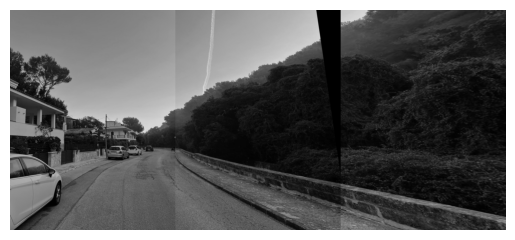

'panoramic_image_updated_prueba.png'

In [90]:
# Nombres de archivo de las imágenes de entrada
filenames = ['IMG_IZQ.JPG', 'IMG_MID.JPG', 'IMG_DER.JPG']
H_filenames = ['H_IZQ.jpeg', 'H_MID.jpeg', 'H_DER.jpeg']
V_filenames = ['V_IZQ.jpeg', 'V_MID.jpeg', 'V_DER.jpeg']
profe_filenames = ['img1.png','img2.png','img3.png']

images = [cv2.imread(f) for f in H_filenames]
images_grey = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Detectamos características en las imágenes en escala de grises
kps_des = detect_features(images_grey)

# Emparejamos los descriptores entre la primera y la segunda imagen
matches12 = match_descriptors(kps_des[0][1], kps_des[1][1])

# Unimos las primeras dos imágenes
result_12 = stitch_images(images_grey[0], images_grey[1], kps_des[0][0], kps_des[1][0], matches12)

# Detectamos características en la imagen resultante de la unión de la primera y segunda imagen
kp_result_12, desc_result_12 = detect_features([result_12])[0]

# Detectamos características en la tercera imagen
kp_image_3, desc_image_3 = detect_features([images_grey[2]])[0]

# Emparejamos los descriptores entre la imagen compuesta y la tercera imagen
matches_12_3 = match_descriptors(desc_result_12, desc_image_3)

# Unimos el resultado anterior con la tercera imagen
result_123 = stitch_images(result_12, images_grey[2], kp_result_12, kp_image_3, matches_12_3)

# Guardamos y mostramos el resultado
output_filename = 'panoramic_image_updated_prueba.png'
cv2.imwrite(output_filename, result_123)

# Vamos a cargar y mostrar la imagen para verificar el resultado
result_123_color = cv2.cvtColor(result_123, cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.cvtColor(result_123_color, cv2.COLOR_BGR2RGB)) # Convertir BGR a RGB para mostrar correctamente
plt.axis('off') # Ocultar los ejes
plt.show()

output_filename